# Working with ASF processed RTC imagery: VRT approach

This is a notebook demonstrates working with Sentinel-1 RTC imagery that has been processsed on the ASF On-Demand server and downloaded locally. 

The access point for data in this notebook is a directory containing un-zipped directories of RTC scenes.

The previous notebook demonstrated an approach using the xarray function `open_mfdataset()`. Because of the size and some  characteristics of the dataset, this approach can be computationally expensive. Another way to approach reading in large amounts of data to avoid these issues is to use the gdal `build_vrt` command. You will see that this approach let's you read in the data stack with less computational expense, but because of how the data is represented, some metadata is lost and must be re-structured. We will go through those steps here, with explanations of the xarray tools we use along the way. 

**Learning goals**:

Handling large amounts of locally stored data
- organize large set of geotiff files stored locally
- reading in large data stacks as xarray objects using gdal build VRT
    
**NOTE**: code for submitting HyP jobs still needs to be added back in

## Software and setup

In [1]:
import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask
import holoviews as hv
from holoviews import opts


We'll use this function later but defining it now:

In [2]:
# read in PC data (We will use this later for a comparison)
#we'll use this function to get bounding box coordinates from a list of points 
def points2coords(pt_ls): #should be [xmin, ymin, xmax, ymax]
    
    coords_ls = [(pt_ls[0], pt_ls[1]), (pt_ls[0], pt_ls[3]),
                 (pt_ls[2], pt_ls[3]), (pt_ls[2], pt_ls[1]),
                 (pt_ls[0], pt_ls[1])]
    return coords_ls
    



Initialize a `dask.distributed` client:

```{admonition} Head's up! 
On my local machine, I ran into issues initially when the cluster was running on processes rather than threads. This caused system memory issues and many dead kernels. Setting `processes=False` seemed to fix these issues
```

Set up some string variables for directory paths. We need to pass `xr.open_mfdataset()` a list of all files to read in. Currently, the file structure is organized so that each scene has its own sub-directory within `unzipped_keep`. Within each sub-directory are several files - we want to extract the tif files containing RTC imagery for the VV and VH polarizations for each scene. The function `extract_tif_fnames()` takes a path to the directory containing the sub-directories for all scenes and returns a list of the filenames for VV-polarization tif files and a separate list of filenames for VH-polarization tif files.

In [3]:
dir_path_all = '/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/'
scenes_ls = os.listdir(dir_path_all)

def extract_tif_fnames(scene_path):
    ''' return a list of files associated with a single S1 scene'''
    scene_files_ls = os.listdir(dir_path_all + scene_path)
    
    scene_files_vv = [fname for fname in scene_files_ls if fname.endswith('_VH.tif')]
    scene_files_vh = [fname for fname in scene_files_ls if fname.endswith('_VV.tif')]
    scene_files_ls = [fname for fname in scene_files_ls if fname.endswith('_ls_map.tif')]
    
    return scene_files_vv, scene_files_vh, scene_files_ls

Now we need to attach the filenames to the full path to each file. We will end up with a list of 

In [4]:
fpaths_vv, fpaths_vh, fpaths_ls = [],[],[]

for element in range(len(scenes_ls)):
    
    good_files = extract_tif_fnames(scenes_ls[element])
    
    path_vh = dir_path_all + scenes_ls[element] + '/' + good_files[0][0]
    path_vv = dir_path_all + scenes_ls[element] + '/' + good_files[1][0]
    path_ls = dir_path_all + scenes_ls[element] + '/' + good_files[2][0]
    
    fpaths_vv.append(path_vv)
    fpaths_vh.append(path_vh)
    fpaths_ls.append(path_ls)

### Clip stack to AOI

We will use this vector data object later but we will read it in as a `geopandas.GeoDataFrame` object now

In [5]:
#pc_aoi = gpd.read_file('https://github.com/e-marshall/s1_book/raw/main/data/hma_lakes_aoi.geojson')
pc_aoi = gpd.read_file('/home/emmamarshall/Desktop/siparcs/s1_book/data/hma_lakes_aoi.geojson')
pc_aoi

,geometry
0,"POLYGON ((619420.000 3089790.000, 628100.000 3..."


<AxesSubplot:>

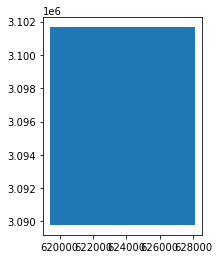

In [6]:
pc_aoi.plot()

## VRT approach:

We will be using the `gdalbuildvrt` command. You can find out more about it [here](https://manpages.ubuntu.com/manpages/bionic/man1/gdalbuildvrt.1.html). This command can make a VRT that either tiles the listed files into a large mosaic, or places them each in a separate band of the VRT. Because we are dealing with a temporal stack of images we want to use the `-separate` flag to place each file into a band of the VRT. </br>
Because we are making a VRT from a large number of files, we'll supply a text file with the full path for each file rather than include these at the end of the command line. We'll use the same lists of filepaths that we used in the `xr.open_mfdataset()` approach but this time we will write them to text files that we pass to the `gdalbuildvrt` command.

In [7]:
with open('/home/emmamarshall/Desktop/data/written_data/s1_vv_fpaths.txt','w') as fp:
    for item in fpaths_vv:
        #write each item on a new line
        fp.write('%s\n' % item)

with open('/home/emmamarshall/Desktop/data/written_data/s1_vh_fpaths.txt','w') as fp:
    for item in fpaths_vh:
        fp.write('%s\n' % item)

with open('/home/emmamarshall/Desktop/data/written_data/s1_ls_fpaths.txt','w') as fp:
    for item in fpaths_ls:
        fp.write('%s\n' % item)

Next, we will use gdal in the command line to create the VRT objects. The commands looks like: 

`gdalbuildvrt -separate -input_file_list /path/to/my_list.txt vrt_fname.vrt` </br>

The above command should be executed for each of the three file name lists (VH, VV, LS)

Read in the VRT files using the `rioxarray` function `open_rasterio()`:

In [8]:
vrt_vv = rio.open_rasterio('/home/emmamarshall/Desktop/siparcs/s1_stackVV.vrt', chunks='auto').squeeze()
vrt_vh = rio.open_rasterio('/home/emmamarshall/Desktop/siparcs/s1_stackVH.vrt', chunks='auto').squeeze()
vrt_ls = rio.open_rasterio('/home/emmamarshall/Desktop/siparcs/s1_stackLS.vrt', chunks='auto').squeeze()

Building the `VRT` object assigns every object in the .txt file to a different band. In doing this, we lost the metadata that is associated with the files. We use a function that is similar (in some ways) to the `preprocess` call above, to extract metadata from the file name and attach it to the xarray objects that we read in from VRTs.

In [9]:
def extract_metadata_attrs(inputfname):
    
    #vv_fn = da_orig.encoding['source'][113:]
    vv_fn = inputfname[113:]
    
    sensor = vv_fn[0:3]
    beam_mode = vv_fn[4:6]
    acq_date_raw = vv_fn[7:15] #need to parse further
    acq_date = datetime.strptime(acq_date_raw, '%Y%m%d')
    acq_time = vv_fn[15:22]
    pol_type = vv_fn[24:25] # dual pol ...
    primary_pol = vv_fn[25:26] # VV ...
    orbit_type = vv_fn[26:27] #Precise (P), Restituted (R), or Original Predicted (O)
    terrain_correction_pixel_spacing = vv_fn[27:32] #Terrain Correction Pixel Spacing
    rtc_alg = vv_fn[33:34] #Software Package Used: GAMMA (G)
    output = vv_fn[35] #  Gamma-0 (g) or Sigma-0 (s) Output
    output_type = vv_fn[36] #Power (p) or Decibel (d) or Amplitude (a) Output
    masked = vv_fn[37]  #Unmasked (u) or Water Masked (w)
    filtered = vv_fn[38]  # Not Filtered (n) or Filtered (f)
    area =  vv_fn[39]       # Entire Area (e) or Clipped Area (c)
    tbd =   vv_fn[40]   #Dead Reckoning (d) or DEM Matching (m)
    product_id  = vv_fn[42:46]  #Product ID

    attrs_dict = { 'sensor': sensor,
                        'beam_mode':beam_mode, 
                        'acquisition_date' : acq_date,
                        'acquisition_time': acq_time,
                        'polarisation_type': pol_type,
                        'primary_polarisation': primary_pol,
                        'orbit_type': orbit_type,
                        'terrain_correction_pixel_spacing' : terrain_correction_pixel_spacing,
                        'output_format': output,
                        'output_type': output_type,
                        'masked' : masked,
                        'filtered':filtered,
                        'area':area,
                        'product_id': product_id 
                 }
    return attrs_dict

Create the attributes dictionary, then create a list of acquisition dates. This will be the common dimension that we use to apply the metadata to the xarray objects.

In [10]:
#make a dict of metadata sorted by acq_date
#the keys will be acq date
acq_dates_ls_vv = [extract_metadata_attrs(fpaths_vv[file])['acquisition_date'].strftime('%m/%d/%Y') for file in range(len(fpaths_vv))]
#the values will be the rest of the metadata (a dict itself0
meta_attrs_ls_vv = [extract_metadata_attrs(fpaths_vv[file]) for file in range(len(fpaths_vv))]
meta_tuple_vv = tuple(zip(acq_dates_ls_vv, meta_attrs_ls_vv))



#meta_ls = [(datetime.strptime(key, '%m/%d/%Y'), meta_dict_vv[key]) for key in meta_dict_vv]
meta_ls = [(datetime.strptime(meta_tuple_vv[key][0], '%m/%d/%Y'), meta_tuple_vv[key][1]) for key in range(len(meta_tuple_vv))]
len(meta_ls)

103

The acquisition dates for VV and VH **should be** the same. As a check, you can confirm this by creating both objects and comparing them.

In [11]:
#do the same for vh and make sure they are the same
acq_dates_ls_vh = [extract_metadata_attrs(fpaths_vh[file])['acquisition_date'].strftime('%m/%d/%Y') for file in range(len(fpaths_vh))]
meta_attrs_ls_vh = [extract_metadata_attrs(fpaths_vh[file]) for file in range(len(fpaths_vh))]
meta_tuple_vh = tuple(zip(acq_dates_ls_vh, meta_attrs_ls_vh))

In [12]:
#are they the same?
meta_tuple_vv == meta_tuple_vh

True

Great, now we have a dictionary where the keys are time stamps corresponding with acquisition dates and the values are associated metadata. The problem is that we want to sort this metadata by time, but dictionaries are by nature **unsorted**. So, we can create a list of tuples out of our dictionary:

Okay, we want to convert our dict to a list of tuples, where each dict item is its own tuple. so the [0] element of each tuple will be the dict key and the following will be the values. <br>
First we will re-organize our nested dictionary of metadata as a list of tuples containing dictionaries containing metadata.

In [13]:
#this will be a list of tuples where the first element of each tuple is the former dictionary key (acquisition date) and the second is the dictionary of associated metadata
meta_ls = [(datetime.strptime(meta_tuple_vv[key][0], '%m/%d/%Y'), meta_tuple_vv[key][1]) for key in range(len(meta_tuple_vv))]
#now sort this by time
meta_sort = sorted(meta_ls, key=lambda y:y[0])

We can now assign the list of acquisition dates as coordinates to the xarray objects. Use `pd.to_datetime()` to do this as time-aware coordinate values.

In [14]:
vrt_vv = vrt_vv.assign_coords({'band':pd.to_datetime(acq_dates_ls_vv, format='%m/%d/%Y')})
vrt_vh = vrt_vh.assign_coords({'band':pd.to_datetime(acq_dates_ls_vh, format='%m/%d/%Y')})
vrt_vv

<xarray.DataArray (band: 103, y: 13379, x: 17452)>
dask.array<open_rasterio-36df041fcb90c3cdeff31cb783945a2f<this-array>, shape=(103, 13379, 17452), dtype=float32, chunksize=(1, 5760, 5760), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [15]:
type(vrt_vv)
type(vrt_vh)

xarray.core.dataarray.DataArray

Merge the two `xr.DataArrays` together into an `xr.Dataset`.

In [16]:
vrt_merge = xr.Dataset({'vv':vrt_vv, 
                      'vh':vrt_vh}).rename_dims({'band':'time'}).rename({'band':'time'})
vrt_merge

<xarray.Dataset>
Dimensions:      (time: 103, x: 17452, y: 13379)
Coordinates:
  * time         (time) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 0
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>

The files are not organized by time in the directory, so the files are not read in in temporal order when we create the VRT and `xr.Dataset` objects. Once we have attached the temporal metadata to the xarray objects composed from VRT, we can use `.sortby()` to organize the dataset along time time dimension:

In [17]:
vrt_merge = vrt_merge.sortby(vrt_merge.time)
vrt_merge

<xarray.Dataset>
Dimensions:      (time: 103, x: 17452, y: 13379)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 0
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>

You can see that the chunking here is much more reasonable, with 1236 total chunks compared to 103 or 317,240 chunks from the `open_mfdataset()` approach.

Clip the full object by the same AOI as above:

In [18]:
vrt_clip = vrt_merge.rio.clip(pc_aoi.geometry, pc_aoi.crs)
vrt_clip

<xarray.Dataset>
Dimensions:      (time: 103, x: 290, y: 396)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

### One more thing....

We've managed to attach the acquisition date information as coordinates to the VRT-built xarray objects, but there is but more information contained in the metadata dictionary than that. Let's work on a way to attatch the information from the dictionary to appropriate elements of the xarray object.

In [19]:
meta_sort[0][0]

datetime.datetime(2021, 5, 2, 0, 0)

In [20]:
str(vrt_clip.time.data[0])[:-19]

vrt_clip.isel(time=0).time.data

array('2021-05-02T00:00:00.000000000', dtype='datetime64[ns]')

In [40]:
len(vrt_clip.time.data)
len(meta_sort)
meta_sort[0][1]

{'sensor': 'S1A',
 'beam_mode': 'IW',
 'acquisition_date': datetime.datetime(2021, 5, 2, 0, 0),
 'acquisition_time': 'T121414',
 'polarisation_type': 'V',
 'primary_polarisation': 'P',
 'orbit_type': '_',
 'terrain_correction_pixel_spacing': 'RTC30',
 'output_format': 'g',
 'output_type': 'p',
 'masked': 'u',
 'filtered': 'n',
 'area': 'e',
 'product_id': '1424'}

In [58]:
vrt_clip.vv.isel(time=0).assign_attrs({'blah':'blah'})

<xarray.DataArray 'vv' (y: 396, x: 290)>
dask.array<getitem, shape=(396, 290), dtype=float32, chunksize=(396, 290), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2021-05-02
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    0.0
    blah:          blah

In [60]:
def assign_metadata(data, metadata):
    
    ds_attrs = data.sel(time=metadata[time][0]).assign_attrs(metadata[time][1] for time in range(len(metadata))) 
    
    return ds_attrs

In [61]:
test = assign_metadata(vrt_clip, meta_sort)

NameError: name 'time' is not defined

In [52]:
xr.apply_ufunc(
    assign_metadata,
    vrt_clip,
    meta_sort,
    dask='allowed',
)

AttributeError: 'Array' object has no attribute 'assign_attrs'

In [49]:
vrt_clip

<xarray.Dataset>
Dimensions:      (time: 103, x: 290, y: 396)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [24]:
def assign_meta(input_xr, metadata):
    
    '''this assigns attrs to a single time step of an xr object from a single element of a list of tuples containing metadata'''
    
    input_xr = input_xr.assign_attrs(metadata)
    
    return input_xr

In [26]:
vrt_new = vrt_clip.sel(time=meta_sort[time][0]).assign_attrs(meta_sort[time][1] for time in range(len(meta_sort)) if meta_sort[time][0] == vrt_clip.sel(time=time).time.data)

NameError: name 'time' is not defined

In [36]:
def scaled_assign_meta(input_xr, meta_tuple = meta_sort):
    
    ''' this should be a wrapper to apply to teh entire data cube of xr object'''
    
   # if (datetime.strptime(str(input_xr.isel(time=[time].time.data)[:-19], '%Y-%m-%d')) == (meta_tuple[time][0]):
                         
    input_xr.sel(time=meta_tuple[time][0]).assign_attrs(meta_tuple[time][1])
                     
    return input_xr

In [37]:
vrt_fake = vrt_clip.map(scaled_assign_meta)

NameError: name 'time' is not defined

In [22]:
def fix_meta(input_xr, meta_tuple):

    for time in range(len(input_xr.time.data))[:5]:
        date1 = str(input_xr.isel(time=[time]).time.data[0])[:-19]
    
        date2 = datetime.strptime(date1, '%Y-%m-%d')
    
        date_dict = meta_tuple[time][0]
    
        print(date2)
        print(date_dict)
        print('')

        if date_dict == date2:

            input_xr.sel(time=meta_tuple[time][0]).assign_attrs(meta_tuple[time][1])

        else: 
            print(meta_tuple[time][0])
            print('no')
            
        return input_xr


In [23]:
vrt_fake = vrt_clip.isel(time=0).assign_attrs(meta_sort[0][1])
vrt_fake

<xarray.Dataset>
Dimensions:      (x: 290, y: 396)
Coordinates:
    time         datetime64[ns] 2021-05-02
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (y, x) float32 dask.array<chunksize=(396, 290), meta=np.ndarray>
    vh           (y, x) float32 dask.array<chunksize=(396, 290), meta=np.ndarray>
Attributes: (12/14)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-05-02 00:00:00
    acquisition_time:                  T121414
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    output_format:                     g
    output_type:                       p
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        1424

In [27]:
vrt_new = vrt_clip.sel(time=meta_sort[time][0]).assign_attrs(meta_sort[time][1] for time in range(len(meta_sort)))

NameError: name 'time' is not defined

In [226]:
vrt_fix = fix_meta(vrt_clip, meta_sort)
vrt_fix

2021-05-02 00:00:00
2021-05-02 00:00:00



<xarray.Dataset>
Dimensions:      (time: 103, x: 290, y: 396)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [228]:
vrt_fix.isel(time=0)

<xarray.Dataset>
Dimensions:      (x: 290, y: 396)
Coordinates:
    time         datetime64[ns] 2021-05-02
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (y, x) float32 dask.array<chunksize=(396, 290), meta=np.ndarray>
    vh           (y, x) float32 dask.array<chunksize=(396, 290), meta=np.ndarray>

In [110]:
def attach_metadata_to_stack(input_xr, meta_dict):
    '''this function is designed to be used for re-assigning metadata stored in filenames to an xarray object created from a gdal VRT object. 
    The metadata is extracted from the filename list used to create the vrt, formatted as a dictionary and assigned to appropriate elements of the xarray object'''
    
    #the order of dates is flipped btw the dict keys and the xr object. fix that first:
    dates = [date for date in list(meta_dict.keys())]
    
    yr,mo,day = [dates[obj][-4:] for obj in range(len(dates))], [dates[obj][:2] for obj in range(len(dates))], [dates[obj][3:5] for obj in range(len(dates))]
   
    date = ['{yr}/{mo}/{day}'.format(yr = yr[obj], mo = mo[obj], day = day[obj]) for obj in range(len(yr))]
    
    
    

In [154]:
def flip_date(input_date):
    
    new_date = '{yr}-{mo}-{day}'.format(yr = input_date[-4:],
                             mo = input_date[:2],
                             day = input_date[3:5])
    
    return new_date

In [186]:
flip_date('08/21/2022')

'2022-08-21'

In [189]:
def attach_metadata1(input_xr_step, dict_item):
    #should be a single time step of xr obj
    input_xr_step = input_xr_step.assign_attrs(dict_item)
    return input_xr_step

In [ ]:
def metadata_wrapper(input_xr_full, dictionary):
    
    for key, items in dictionary.items():
        
        date = flip_date(key)
    
        map(lambda x: 

In [187]:
def attach_metadata(input_xr, meta_dict):
    
    for key, items in meta_dict.items():
        
        date = flip_date(key)

        for element in range(len(input_xr.time)):
            
            print(str(input_xr.time[element].data)[:-19])
            print(date)
            
            if str(input_xr.time[element].data)[:-19] == date:
                #print(date)
                input_xr.sel(time=date).assign_attrs(meta_dict[key])
                print('yes')
            else: 
                 pass
    return input_xr
    

In [188]:
new_xr = attach_metadata(vrt_clip, meta_dict_vv)

2021-05-02
2021-08-21
2021-05-05
2021-08-21
2021-05-09
2021-08-21
2021-05-14
2021-08-21
2021-05-14
2021-08-21
2021-05-17
2021-08-21
2021-05-21
2021-08-21
2021-05-26
2021-08-21
2021-05-29
2021-08-21
2021-06-02
2021-08-21
2021-06-07
2021-08-21
2021-06-10
2021-08-21
2021-06-14
2021-08-21
2021-06-19
2021-08-21
2021-06-22
2021-08-21
2021-06-26
2021-08-21
2021-07-01
2021-08-21
2021-07-01
2021-08-21
2021-07-04
2021-08-21
2021-07-08
2021-08-21
2021-07-13
2021-08-21
2021-07-13
2021-08-21
2021-07-13
2021-08-21
2021-07-16
2021-08-21
2021-07-20
2021-08-21
2021-07-25
2021-08-21
2021-07-28
2021-08-21
2021-08-01
2021-08-21
2021-08-06
2021-08-21
2021-08-09
2021-08-21
2021-08-13
2021-08-21
2021-08-18
2021-08-21
2021-08-21
2021-08-21
yes
2021-08-25
2021-08-21
2021-08-30
2021-08-21
2021-09-02
2021-08-21
2021-09-06
2021-08-21
2021-09-11
2021-08-21
2021-09-14
2021-08-21
2021-09-18
2021-08-21
2021-09-23
2021-08-21
2021-09-26
2021-08-21
2021-09-30
2021-08-21
2021-10-05
2021-08-21
2021-10-08
2021-08-21
2021-1

In [180]:
new_xr

<xarray.Dataset>
Dimensions:      (time: 103, x: 290, y: 396)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [49]:
meta_dict_vv['08/21/2021']

{'sensor': 'S1A',
 'beam_mode': 'IW',
 'acquisition_date': datetime.datetime(2021, 8, 21, 0, 0),
 'acquisition_time': 'T000314',
 'polarisation_type': 'V',
 'primary_polarisation': 'P',
 'orbit_type': '_',
 'terrain_correction_pixel_spacing': 'RTC30',
 'output_format': 'g',
 'output_type': 'p',
 'masked': 'u',
 'filtered': 'n',
 'area': 'e',
 'product_id': '748F'}

In [53]:
vrt_clip.sel(time='2021/08/21').assign_attrs(meta_dict_vv['08/21/2021'])

<xarray.Dataset>
Dimensions:      (x: 290, y: 396)
Coordinates:
    time         datetime64[ns] 2021-08-21
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (y, x) float32 dask.array<chunksize=(396, 290), meta=np.ndarray>
    vh           (y, x) float32 dask.array<chunksize=(396, 290), meta=np.ndarray>
Attributes: (12/14)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-08-21 00:00:00
    acquisition_time:                  T000314
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    output_format:                     g
    output_type:                       p
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        748F

## Convert from power to db scale 


In [30]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

The first way you might think to do this would be to create a new `xr.Dataset` object out of the `vrt_clip` object by applying `power_to_db()` to each `xr.DataArray` object (see the code below). However, there is an easier way to do this that requires less lines of code and uses more built-in xarray functionality. This is to use the `.map()` or `.apply()` function. `apply()` is a backwards compatible version of `.map()`. Read more about them [here](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.apply.html?highlight=apply()) and [here](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.map.html#xarray.Dataset.map). This powerful function let's us apply the transformation to each variable within an `xr.Dataset` object.

In [29]:
asf_clip_sigma1 = xr.Dataset({'vv':power_to_db(vrt_clip.vv),
                  'vh':power_to_db(vrt_clip.vh)})

In [30]:
asf_clip_sigma1

<xarray.Dataset>
Dimensions:      (time: 103, x: 290, y: 396)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [31]:
asf_clip_sigma_m = vrt_clip.map(power_to_db)
asf_clip_sigma_a = vrt_clip.apply(power_to_db)

In [32]:
asf_clip_sigma_m.equals(asf_clip_sigma_a)

True

In [33]:
asf_clip_sigma_m.equals(asf_clip_sigma1)

True

In [34]:
asf_clip_sigma = asf_clip_sigma_m

## Handle `-inf` values

The nan values in the dataset built from the VRT get turned into `-inf` values, which is a pain to work with so let's replace them with NaNs. To do this, I write a function that uses the `np.where()` function to replace every `-inf` value in a given numpy array with `np.Nan`. Notice that this function takes as an input and returns a numpy array. We want to apply this our entire xarray dataset. Remember that callling `.data` on an `xr.DataArray` (ie. `asf_clip_sigma.isel(band=0).vv.data`) access an object whose type is `dask.array.core.Array`. Dask arrays are essentially an arrangement of numpy arrays, and dask arrays support much of the numpy API. Read more about this [here](https://examples.dask.org/array.html). </br>

That the `.data` object behaves like a numpy array is important because it let's us use functions like xarray's `reduce()` which are designed for applying numpy functionality to xarray objects. You can read more about `reduce()` [here](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.reduce.html) and [here](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.reduce.html). <br>
In this instance, we have the function `replace_infs()` that takes and returns a numpy array, but which we'd like to apply over the entire `xarray.Dataset`, which we can do using `reduce()`. Note that `reduce()` drops the dimensional coordinates so we append the `reduce()` call with `assign_coords()`. 

In [56]:
def replace_infs(input_arr):
    '''replace infs in data w nan'''
    return np.where(input_arr == np.NINF, np.nan, input_arr)

In [57]:
asf_clip_sigma = asf_clip_sigma.reduce(replace_infs)
asf_clip_sigma

<xarray.Dataset>
Dimensions:      (time: 103, y: 396, x: 290)
Coordinates:
    spatial_ref  int64 0
Dimensions without coordinates: time, y, x
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

`.reduce()` drops the object coordinatse. Below we re-run the `.reduce()` command and assign coordinates to our reduced object within the same line of code: 

In [38]:
asf_clip_sigma = asf_clip_sigma.reduce(replace_infs).assign_coords({'x':vrt_clip.x,
                                                                    'y':vrt_clip.y,
                                                                    'time':vrt_clip.coords['time']})

In [39]:
asf_clip_sigma

<xarray.Dataset>
Dimensions:      (time: 103, y: 396, x: 290)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * time         (time) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

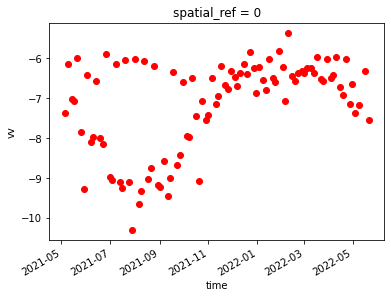

In [41]:
asf_clip_sigma.vv.mean(dim=['x','y']).plot(linestyle='None', marker='o', color='red')

# Comparing RTC datasets

To compare the ASF and Microsoft Planetary Computer (PC) datasets, we will read in the same dataset that we accessed in the earlier notebook:

In [61]:
from pystac_client import Client

catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
catalog

time_range = '2021-01-01/2022-08-01'
bbox = [88.214935, 27.92767, 88.302,  28.034]

bbox_coords = points2coords(bbox)
bbox_coords

search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

import stackstac
import os
import planetary_computer

time_range = '2021-01-01/2022-08-01'
bbox = [88.214935, 27.92767, 88.302,  28.034]

bbox_coords = points2coords(bbox)
bbox_coords

#print(os.environ.get('PC_SDK_SUBSCRIPTION_KEY'))
#bounds_latlon=bbox,
da_pc = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bbox, epsg=32645, #resolution = 50
)
da_pc

,Array,Chunk
Bytes,1.54 GiB,6.79 MiB
Shape,"(100, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,3 Graph Layers,400 Chunks
Type,float64,numpy.ndarray


Now we have two stacks of Sentinel-1 RTC imagery clipped to the same spatial extent. Let's take an initial look at the similarities and differences between these two datasets.

First, we see that the ASF dataset appears to have a lower spatial resolution than the PC dataset (differing lengths of the x- and y- dimensions). Looking into the metadata (attributes) of each, we confirm this by seeing that the ASF dataset has 30m resolution while the PC dataset has 10m resolution. 

In [68]:
#fig,ax = plt.subplots(figsize=(12,8))
#asf_clip_sigma.vv.mean(dim=['x','y']).plot(ax=ax, color = 'blue', linestyle='None', marker='o', markersize=5)
#pc_sigma.sel(band='vv').mean(dim=['x','y']).plot(ax=ax, color='red', linestyle='None', marker='o', markersize=5)